# K-Clustering Tool for Edge Devices

## Table of Contents

### 1. Feature Definition and Data Collection
- Select measurable features suitable for edge devices (size, color, brightness, sensor data).
- Collect data from devices or public datasets.
- Normalize and store data efficiently for limited hardware.

### 2. K-Means Classification on Edge Devices
- Implement a lightweight K-Means algorithm optimized for CPU/GPU constraints.
- Use reduced memory operations and optional medoid-style center updates.
- Demonstration: Mango classification using the [dataset](https://www.kaggle.com/code/muhammadmuzammil196/k-mean-mangoes-clustering).
- Compare center initialization methods:
  - Random
  - PCA-based
  - Nearest raw point (K-Medoids approach)
- Final script executes the full pipeline and shows result variation based on initial centers.

### 3. Integration with Split Inference
- Extract features on the edge device to minimize bandwidth.
- Perform clustering locally for real-time classification.
- Offload model retraining to the cloud.
- Synchronize updated cluster centers back to devices with minimal data transfer.
### 4. Resource 
- [StackOverflow](https://stackoverflow.com/questions/35952124/how-to-choose-initial-centroids-for-k-means-clustering)
- [Init centroids smarter](https://medium.com/@atharv4study/k-means-smarter-initialization-for-better-clustering-6914a473e1c7)



### 1. Define feature and collect data 

### 2. Build algorithm 

In [129]:
# declare a variable and libraries 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time


In [130]:
# config 
train_percent = 0.8
num_clusters = 2
max_iterations = 1000000

In [131]:
def euclidean_distance(point1, point2):
    # Calculate the Euclidean distance between two points use math module because numpy usage a lof of memory
    dis = 0 
    for x_i , y_i in zip(point1, point2):
        dis += (x_i - y_i) ** 2
    return math.sqrt(dis)

def D(P , centroids ):
    min_distance = 1e9
    for centroid in centroids:
        min_distance = min(min_distance, euclidean_distance(P , centroid))

    return min_distance

def get_new_centroid(centroids , points):
    new_centroids = None 
    max_distance =  -1 
    for point in points: 
        dist = D(point , centroids)
        # print(f"Point: {point}, Distance: {dist**2 }")
        if dist > max_distance and point not in centroids:
            max_distance = dist
            new_centroids = point
    
    return new_centroids
def pca_manual(X, k):
    X_center = X - np.mean(X, axis=0)

    cov = np.cov(X_center, rowvar=False)

    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    idx = np.argsort(eigen_vals)[::-1]
    eigen_vecs = eigen_vecs[:, idx]

    W = eigen_vecs[:, :k]

    return X_center @ W





In [132]:
import math

def pca_cluster_center(data, k):
    """ Select k cluster centers using PCA-based farthest-point heuristic.
    Args:
        data: list of data points (each is a list of features)        
        k: number of centers to select
    Returns:
        centers: list of k selected centers (each is a list of features)
    """
    # ---------- Helper ----------
    def mean(values): return sum(values) / len(values)
    def dot(a,b): return sum(a[i]*b[i] for i in range(len(a)))
    def norm(v): return math.sqrt(sum(x*x for x in v))
    def mat_vec_mul(M,v): return [dot(row,v) for row in M]

    # 1) Subtract mean
    cols = len(data[0])
    means = [mean([row[i] for row in data]) for i in range(cols)]
    X = [[row[i] - means[i] for i in range(cols)] for row in data]

    # 2) Covariance
    n = len(X)
    cov = [[0]*cols for _ in range(cols)]
    for i in range(cols):
        for j in range(cols):
            s = sum(X[k][i]*X[k][j] for k in range(n))
            cov[i][j] = s / (n - 1)

    # 3) eigenvector via power iteration (only 1 PC -> flatten)
    def power_iteration(M, iter=500):
        v = [1]*len(M)
        for _ in range(iter):
            v = mat_vec_mul(M, v)
            v = [x/norm(v) for x in v]
        return v

    pc1 = power_iteration(cov)

    # 4) Project (flat PCA 1D)
    proj = [dot(row, pc1) for row in X]  # list of scalars

    # 5) Pick k centers using farthest-point heuristic
    used = []
    # pick the point with biggest value first
    first = max(range(len(proj)), key=lambda i: proj[i])
    used.append(first)

    # pick next farthest from current chosen centers
    while len(used) < k:
        idx = max(range(len(proj)), key=lambda i: min(abs(proj[i]-proj[j]) for j in used))
        used.append(idx)

    # 6) Return centers in original space
    centers = [data[i] for i in used]
    return centers


def kmeans(x, y, num_clusters, max_iterations):
    """ Perform K-means clustering.
    Args:       
        x: list of x-coordinates of data points
        y: list of y-coordinates of data points
        num_clusters: number of clusters
        max_iterations: maximum number of iterations
    Returns:
        centers: list of cluster centers (nearest real points)
        clusters: list of clusters, each cluster is a list of data points
        initial_centers: list of initial centers chosen before iterations
    """
    # Combine x and y into a list of points
    points = list(zip(x, y))
    # centers = pca_cluster_center(points, num_clusters)
    centers = random.sample(points, 1)

    while len(centers) < num_clusters:
        new_center = get_new_centroid(centers, points)
        centers.append(new_center)

    # Snapshot the initial centers (before iterative updates)
    initial_centers = centers.copy()

    # plot the initial centers (optional visual inside kmeans, but we'll plot in caller)
    # plt.scatter([center[0] for center in centers], [center[1] for center in centers], color='black', marker='x', s=100, label='Initial Centers')
    
    for iteration in range(max_iterations):
        clusters = [[] for _ in range(num_clusters)]
        
        # Assign points to the nearest cluster center
        for point in points:
            distances = [euclidean_distance(point, center) for center in centers]
            closest_center = distances.index(min(distances))
            clusters[closest_center].append(point)
        
        # Update cluster centers
        new_centers = []
        for cluster in clusters:
            if cluster:  # Avoid division by zero
                avg_x = sum(p[0] for p in cluster) / len(cluster)
                avg_y = sum(p[1] for p in cluster) / len(cluster)
                new_centers.append((avg_x, avg_y))
            else:
                new_centers.append(random.choice(points))  # Reinitialize empty cluster center
        
        # Check for convergence (if centers do not change)
        if new_centers == centers:
            print(f"Converged after {iteration} iterations.")
            break
        
        centers = new_centers

    # Map centers to nearest actual data points
    final_centers = []
    for center in centers:
        final_centers.append(nearest_point(points, center))
    return final_centers, clusters, initial_centers


In [133]:
def get_center(new_point, centers):
    distances = [euclidean_distance(new_point, center) for center in centers]
    closest_center = distances.index(min(distances))
    return closest_center   
def nearest_point(raw_points, target):
    # target: (x,y) float center
    # raw_points: list of (x,y) real coordinates from your data
    best = None
    best_dist = float("inf")

    for p in raw_points:
        d = math.sqrt((p[0] - target[0])**2 + (p[1] - target[1])**2)
        if d < best_dist:
            best_dist = d
            best = p

    return best



#### Test on mangoes classification 

In [134]:
import pandas as pd
data_path = '../data/mango2.csv'

data = pd.read_csv(data_path)
print(data.head())
print(len(data))

   GreenMango Length  GreenMangowidth  YelloMangoLength  YelloMangoWidth
0               10.2             10.5               5.6              0.6
1                9.8              9.0               5.6              0.6
2                9.4              9.6               5.2              0.6
3                9.2              9.3               6.0              0.6
4               10.0             10.8               5.6              0.6
151


Before PCA
[10.2, 9.8, 9.4, 9.2, 10.0]
[10.5, 9.0, 9.6, 9.3, 10.8]
After PCA
[-2.27516184 -2.93786143 -3.2236899  -3.4742816  -2.41807607]
[4.64699592 3.24313366 3.90517754 3.64594058 4.97801786]
(-0.8107827510148619, -0.5768258535225398, 5.663463130258136, 5.054602268823979, -0.04040569111788236)


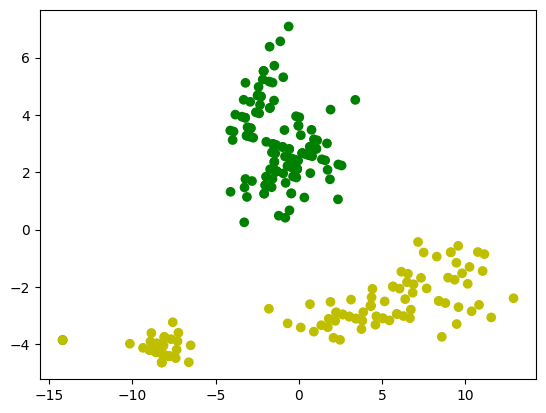

In [135]:
x = list(data['GreenMango Length']) + list(data['YelloMangoLength'])
y = list(data['GreenMangowidth']) + list(data['YelloMangoWidth'])
mango  = [0 for _ in range(len(data['GreenMango Length']))]  + [1 for _ in range(len(data['YelloMangoLength']))]
colors = ['g' , 'y']


print(f"Before PCA")
print(x[:5])
print(y[:5])

X = np.column_stack((x, y))
X_pca = pca_manual(X, k=2)
x = X_pca[: , 0]
y = X_pca[: , 1]
print(f"After PCA")
print(x[:5])
print(y[:5])

pairs = list(zip(x, y, mango))  # Combine them as pairs
random.shuffle(pairs)    # Shuffle the pairs
x, y, mango = zip(*pairs)     # Unzip the pairs back into x and y

train_percent = int(len(x) * train_percent)
x_train , x_test = x[:train_percent], x[train_percent:]
y_train , y_test = y[:train_percent], y[train_percent:]
mango_train , mango_test = mango[:train_percent], mango[train_percent:]

print(x_train[:5])
plt.scatter(x_train, y_train, color=[colors[label] for label in mango_train], marker='o')


(-0.8107827510148619, -0.5768258535225398, 5.663463130258136, 5.054602268823979, -0.04040569111788236)
Converged after 4 iterations.
Centers [(-3.1179795990963077, 1.1413350420815667), (6.396636257737992, -2.424066070959898)]


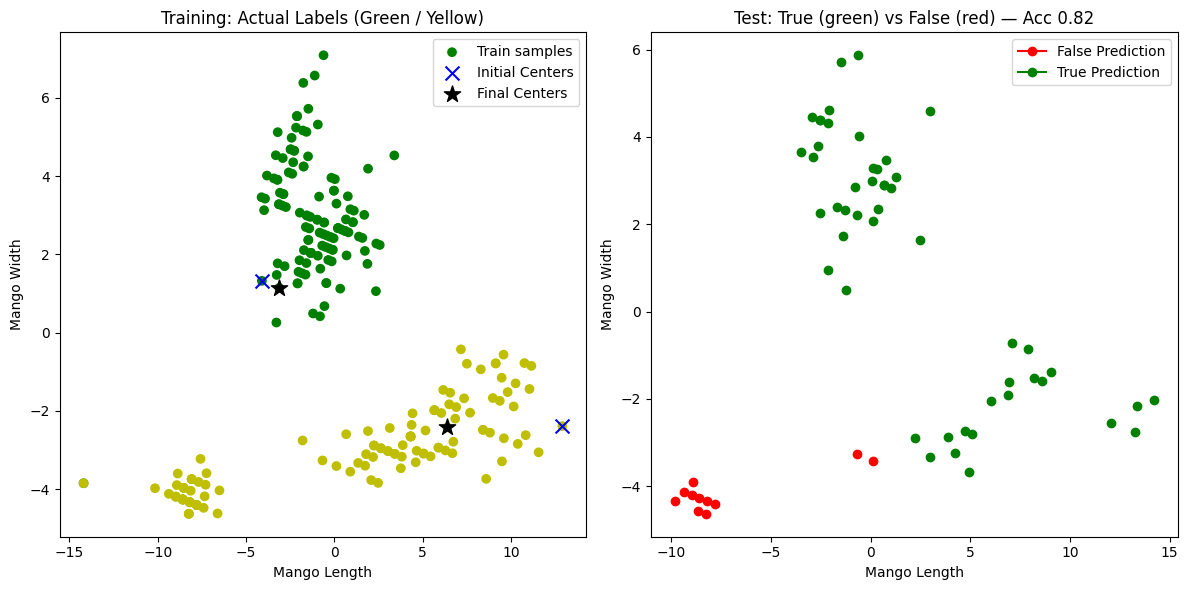

True Predictions: 50, False Predictions: 11
Accuracy: 0.82


In [145]:
def test_kmeans(x_test , y_test , mango_test):
    print(x_train[:5])
    center, cluster, init_centers = kmeans(x_train , y_train , num_clusters, max_iterations)
    pred_mangoes = []
    print("Centers", center)

    # Prepare figure with two subplots: left = actual train labels + init/final centers, right = test predictions (true/false)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

    # Left plot: training samples colored by actual label (green/yellow)
    train_colors = ['g' if m == 0 else 'y' for m in mango_train]
    ax0.scatter(x_train, y_train, color=train_colors, marker='o', label='Train samples')

    # Plot initial centers (use a distinct color/marker)
    if init_centers:
        ax0.scatter([c[0] for c in init_centers], [c[1] for c in init_centers], color='blue', marker='x', s=100, label='Initial Centers')

    # Plot final centers
    if center:
        ax0.scatter([c[0] for c in center], [c[1] for c in center], color='black', marker='*', s=150, label='Final Centers')

    ax0.set_title('Training: Actual Labels (Green / Yellow)')
    ax0.set_xlabel('Mango Length')
    ax0.set_ylabel('Mango Width')
    ax0.legend(loc='best')

    # Build predicted label for each final center by finding nearest training sample's label
    train_points = list(zip(x_train, y_train))
    for i in range(len(center)):
        found = False
        # If the center exactly matches a training point, take its label
        for j, p in enumerate(train_points):
            if abs(p[0] - center[i][0]) < 1e-9 and abs(p[1] - center[i][1]) < 1e-9:
                pred_mangoes.append(mango_train[j])
                found = True
                break
        if not found:
            # otherwise, find nearest training point
            nearest = nearest_point(train_points, center[i])
            idx = train_points.index(nearest)
            pred_mangoes.append(mango_train[idx])

    # Right plot: test samples, colored by prediction correctness (green=true, red=false)
    true_predict = 0
    false_predict = 0
    for i in range(len(x_test)):
        closet_center = get_center((x_test[i], y_test[i]), center)
        pred_label = pred_mangoes[closet_center]
        is_true = (mango_test[i] == pred_label)
        if is_true:
            color = 'g'
            label = 'True Prediction' if true_predict == 0 else ''
            true_predict += 1
        else:
            color = 'r'
            label = 'False Prediction' if false_predict == 0 else ''
            false_predict += 1
        ax1.plot(x_test[i], y_test[i], color=color, marker='o', label=label)

    acc = (true_predict / (true_predict + false_predict)) if (true_predict + false_predict) > 0 else 0.0
    ax1.set_title(f'Test: True (green) vs False (red) — Acc {acc:.2f}')
    ax1.set_xlabel('Mango Length')
    ax1.set_ylabel('Mango Width')
    if true_predict + false_predict > 0:
        ax1.legend(loc='best')

    plt.tight_layout()
    plt.show()

    print(f"True Predictions: {true_predict}, False Predictions: {false_predict}")
    print(f"Accuracy: {true_predict/(true_predict + false_predict):.2f}")


# Run test
test_kmeans(x_test , y_test , mango_test)
